# Анализ гипотез и A/B-теста интернет-магазина (Hypothesis Analysis and A/B Test)

## Описание проекта

Отдел маркетинга крупного интернет-магазина подготовил список гипотез для увеличения выручки.

**Цель работы**: приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

**План работы**:

* Приоритизация гипотез;
    * Изучение общей информации;
    * Описание и применение фреймворков ICE и RICE для приоритизации гипотез;
    * Выводы;
* Анализ A/B-теста
    * Изучение общей информации;
    * Построение графиков;
    * Очистка аномалий в данных;
    * Расчеты статистической значимости различий;
    * Выводы.
    
**Описание данных**

Данные для первой части

Файл `hypothesis.csv`. 

* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части

Файл `orders.csv`. 

* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл `visitors.csv`. 

* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

## Приоритизация гипотез

### Изучение общей информации

Загрузим необходимые библиотеки для работы с данными

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 150

Загрузим данные о гипотезах

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Оптимизируем названия столбцов в таблице

In [3]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.head(10)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Описание фреймворков ICE и RICE

Размерем фреймворки ICE и RICE.

**ICE** (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач. Рассчитывается:

**ICE = Impact * Confidence / Efforts**

У ICE есть модификация **RICE** (R от англ. reach, «охват»):

**RICE = Reach * Impact * Confidence / Efforts**

В формулах:

* Reach — скольких пользователей затронет изменение, которое вы хотите внести;
* Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
* Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
* Efforts — сколько стоит протестировать эту гипотезу.

Параметры фреймворков ICE и RICE оценивают в удобных шкалах: например, от 0 до 10.


### Применение фреймворка ICE для приоритизации гипотез

Применим фреймворк **ICE** для приоритизации гипотез

In [4]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Применение фреймворка RICE для приоритизации гипотез

Применим фреймворк **RICE** для приоритизации гипотез

In [5]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Выводы

При применении **ICE** наиболее перспективными выглядят гипотезы 8, 0, 7, 6. После применения **RICE** уже наиболее перспективными выглядят гипотезы 7, 2, 0, 6. Можно сказать, что гипотезы 0, 7, 6 при использовании обоих методов находятся на первых местах. А вот гипотеза 8 во втором случае резко упала. Так получилось, потому что параметр **Reach** у нее равен 1, а у остальных гипотез он выше. Сравнение гипотез представлены в таблицах ниже, отсортированных по ICE и RICE, соответственно

In [6]:
hypothesis[['hypothesis','ICE','RICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


In [7]:
hypothesis[['hypothesis','ICE','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


## Анализ A/B-теста

### Изучение общей информации

Нам необходимо проанализировать данные А/В-теста.

Загрузим эти данные.

In [8]:
orders = pd.read_csv('orders.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
visitors = pd.read_csv('visitors.csv')
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Изменим тип данных в таблицах для работы с датой.

In [10]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
print(orders.head())
print(visitors.head())
orders.info()
visitors.info()

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     1650     B
1     2804400009  3642806036 2019-08-15      730     B
2     2961555356  4069496402 2019-08-15      400     A
3     3797467345  1196621759 2019-08-15     9759     B
4     2282983706  2322279887 2019-08-15     2308     B
        date group  visitors
0 2019-08-01     A       719
1 2019-08-02     A       619
2 2019-08-03     A       507
3 2019-08-04     A       717
4 2019-08-05     A       756
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(

Проверим, количество групп в тесте и сколько в каждой из них пользователей, а также количество уникальных пользователей в таблице `orders`

In [11]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [12]:
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

In [13]:
orders.groupby('group').agg({'visitorId': 'nunique'})

,visitorId
group,
A,503
B,586


Всего 2 группы, как и было заявлено в тесте.

Найдем даты начала и окончания теста

In [14]:
orders.agg({'date': ['min', 'max']})

,date
min,2019-08-01
max,2019-08-31


Определим, есть ли пользователи, участвующие сразу в двух группах теста

In [15]:
group_a = orders[orders['group'] == 'B']
group_b = orders[orders['group'] == 'A']
pd.merge(group_a,group_b,on='visitorId',how="inner").agg({'visitorId': 'nunique'})

visitorId    58
dtype: int64

Таких пользователей 58.

Проверим таблицы на наличие явных дубликатов

In [16]:
print(orders.duplicated().sum()) 
visitors.duplicated().sum() 

0


0

Явных дубликатов нет

Посмотрим, есть ли в столбцах пропуски

In [17]:
print(orders.isna().sum()) 
visitors.isna().sum() 

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


date        0
group       0
visitors    0
dtype: int64

Пропусков не обнаружено. Но Python показывает пустые значения только, если оно имеет тип NoneType. Необходимо проверить, есть ли другие пропуски в столбцах. Для этого создадим функцию nan_values.

In [18]:
# функция для вывода списка и количества уникальных значений в таблице
def nan_values(df,list_nans = ['',' ','""', '" "', None, np.nan]):
    list_count = []
    list_share = []
    for col in df.columns:
        list_count.append(sum(df[col].isin(list_nans)))
        list_share.append(round(sum(df[col].isin(list_nans)) * 100 / len(df), 2))
    missing_value_df = pd.DataFrame({'column_name': df.columns, 'num_missing': list_count, 'percent_missing': list_share})
    return missing_value_df
display(nan_values(orders)) # применение функции для таблицы 
nan_values(visitors) # применение функции для таблицы 

,column_name,num_missing,percent_missing
0,transactionId,0,0.0
1,visitorId,0,0.0
2,date,0,0.0
3,revenue,0,0.0
4,group,0,0.0


,column_name,num_missing,percent_missing
0,date,0,0.0
1,group,0,0.0
2,visitors,0,0.0


Никаких других пропусков не обнаружено

### Построение графика кумулятивной выручки по группам

Соберём агрегированные кумулятивные по дням данные о заказах

In [19]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования

In [20]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

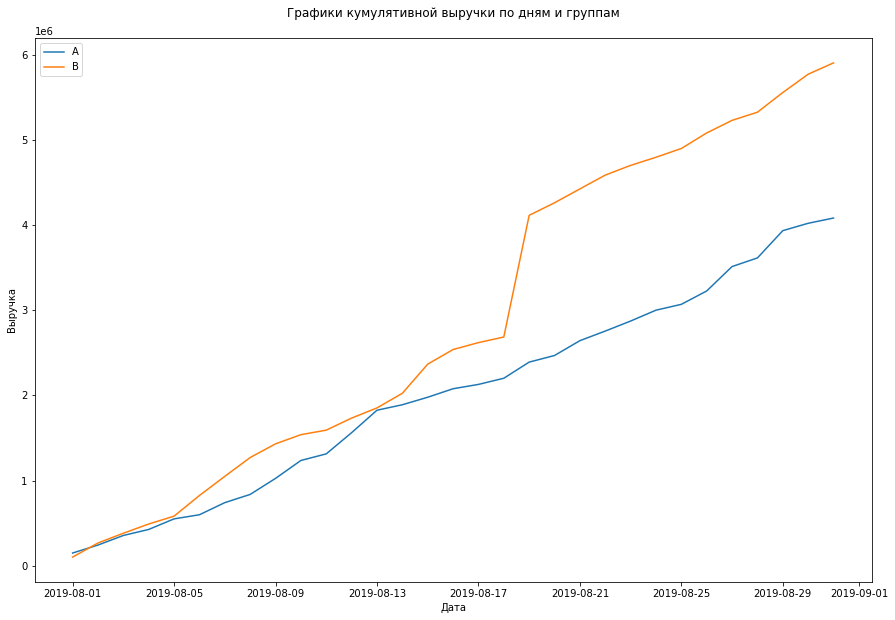

In [21]:
# Строим график выручки группы А
plt.figure(figsize=(15,10))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по дням и группам' + "\n")
plt.legend(); 

Примерно в середине теста сегмент В резко вырвался вперед и продожал лидировать весь остаток теста. Можно предположить, что в данных присутствуют аномально большие суммы заказов. В заключительном анализе стоит это проверить и удалить их.

### Построение графика кумулятивного среднего чека по группам

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

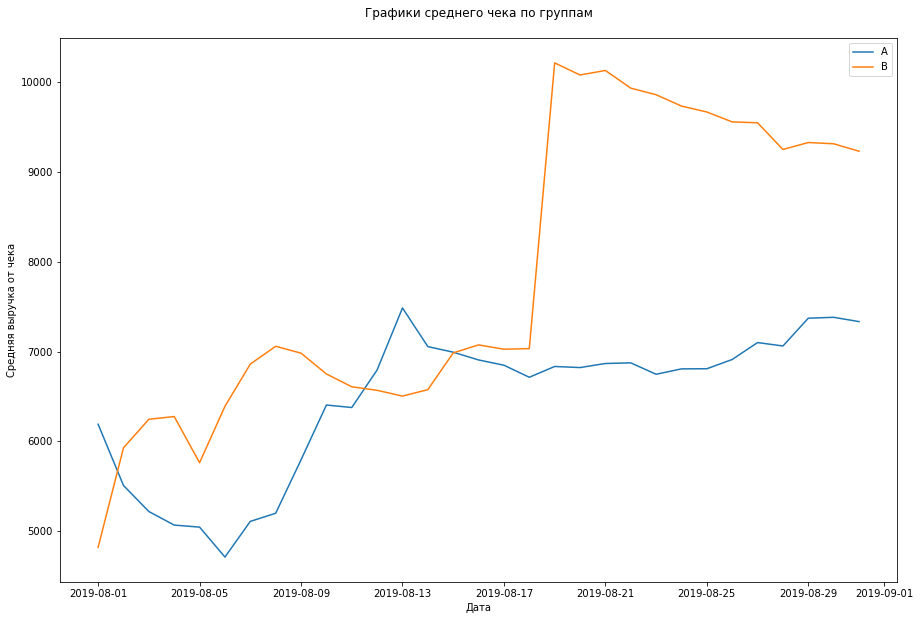

In [22]:
plt.figure(figsize=(15,10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.ylabel('Средняя выручка от чека')
plt.xlabel('Дата')
plt.title('Графики среднего чека по группам' + "\n");
plt.legend(); 

Кумулятивное среднее значение чека по группам по сегментам продолжает колебаться. При этом есть такой же резкий скачок для сегмента В на середине теста, как и на предыдущес графике. Присутствует влияние выбросов на результат.

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного изменения кумулятивного среднего чека группы B к группе A

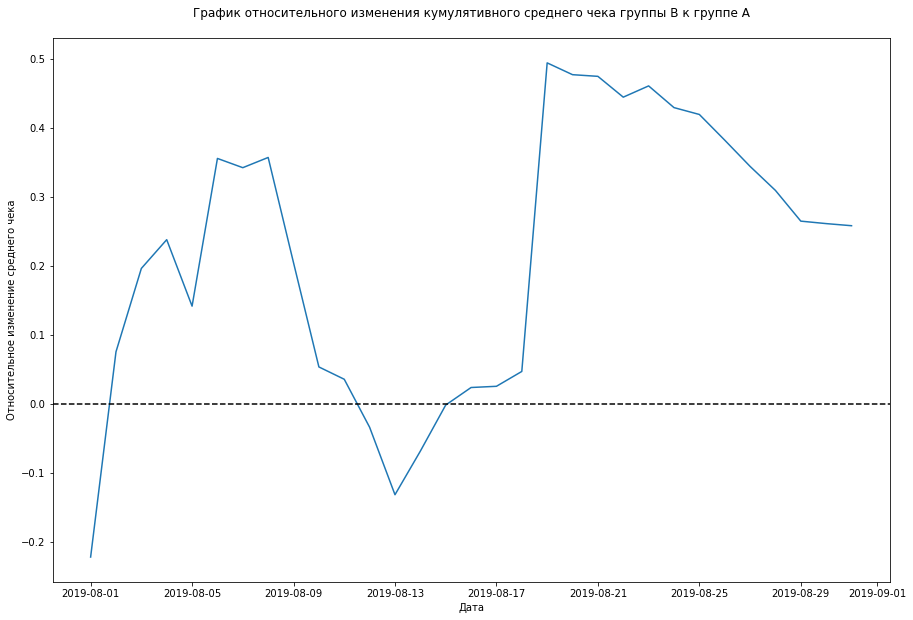

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,10))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.ylabel('Относительное изменение среднего чека')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A' + "\n");


В нескольких точках график различия между сегментами резко меняется. Видимо, тогда были совершены аномальные заказы

### Построение графика кумулятивной конверсии по группам

Проанализируем график кумулятивной конверсии по группам

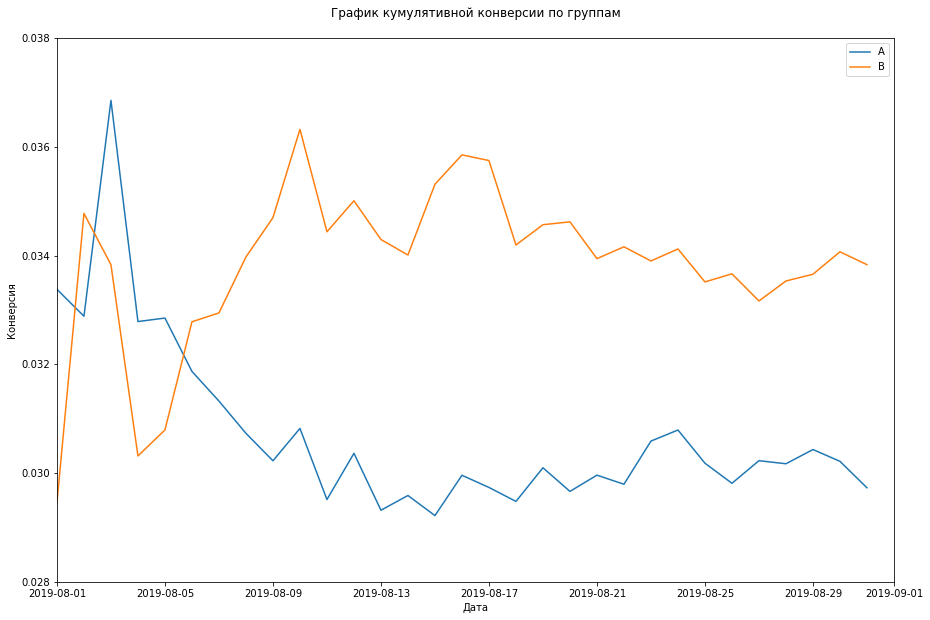

In [24]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,10))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('График кумулятивной конверсии по группам' + "\n");

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.028, 0.038]);

В начале теста сегмент А имел большую конверсию, но затем сегмент В стал выше и зафиксировался примерно у одного значения в 3,5%, а сегмент А остановился примерно на 3%

### Построение графика относительного изменения кумулятивной конверсии группы B к группе A

Построим график относительного изменения кумулятивной конверсии группы B к группе A

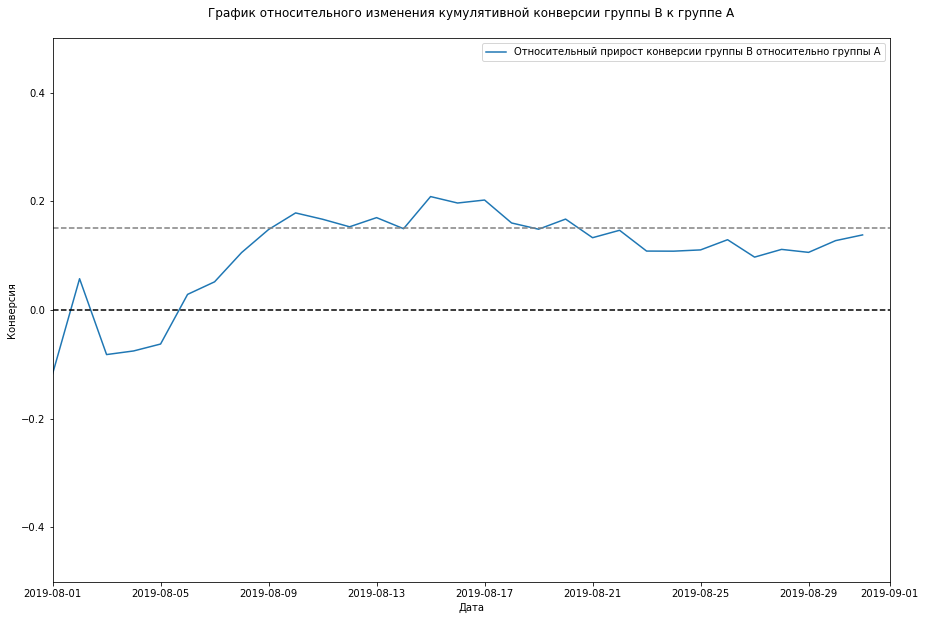

In [25]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,10))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.5, 0.5]) 

plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A' + "\n");

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. В конце теста конверсия сегмента В лидирует на 15% относительно сегмента А. В целом отношение конверсии ещё не установилось, делать какие-либо выводы по тесту нельзя. Необходимо проанализировать аномалии. Этим мы займемся в дальнейшем.

### Построение точечного графика количества заказов по пользователям

Найдем число заказов по пользователям — создадим датафрейм c двумя столбцами: `userId` и `orders`. По этим данным построим точечный график количества заказов по пользователям

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


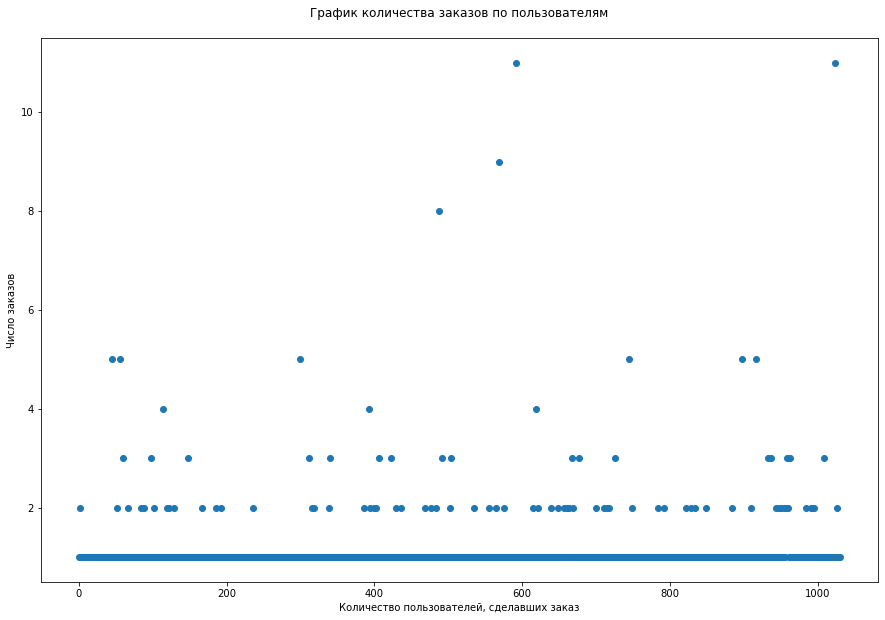

In [26]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers

x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(15,10))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.ylabel('Число заказов')
plt.xlabel('Количество пользователей, сделавших заказ')
plt.title('График количества заказов по пользователям' + "\n");

Пользователей, заказавших более 2 раз, совсем немного. Они могут быть аномальными.

### Расчет 95-го и 99-го перцентиля количества заказов на пользователя

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберим границу для определения аномальных пользователей

In [27]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей совершили больше двух заказов. И не более 1% - больше четырех заказов. Выберим в качестве границы для определения аномальных пользователей - **4 заказа**. Так мы уберём 1% пользователей с наибольшим числом заказов

### Построение точечного графика стоимостей заказов

Построим точечный график стоимостей заказов

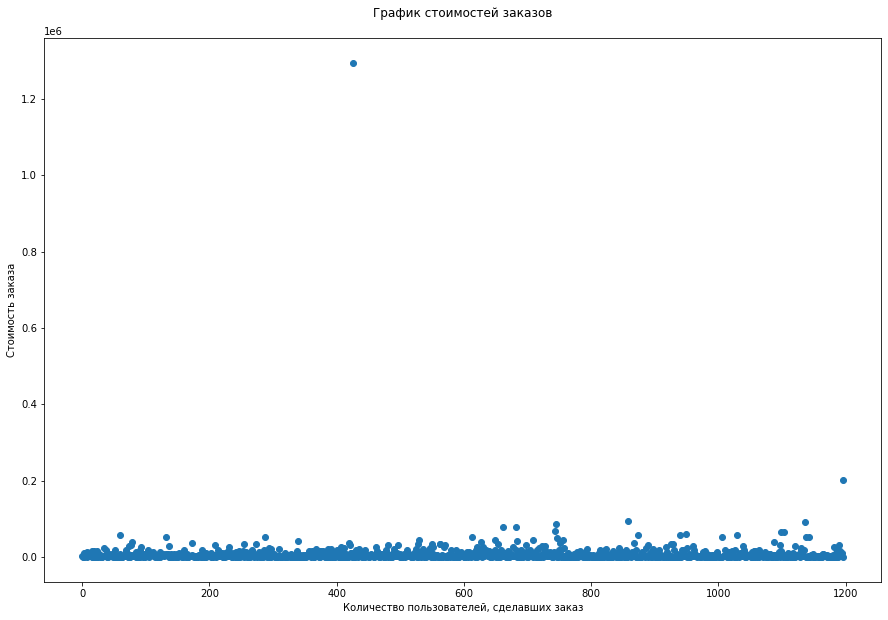

In [28]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15,10))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказа')
plt.xlabel('Количество пользователей, сделавших заказ')
plt.title('График стоимостей заказов' + "\n");

2 значения выбиваются, из-за чего остальные значения сливаются. Удалим выпадающие значения и построим новый график

In [29]:
orders['revenue'].sort_values(ascending=False)

425     1294500
1196     202740
858       93940
1136      92550
744       86620
         ...   
933          60
459          50
756          50
584          50
1091         50
Name: revenue, Length: 1197, dtype: int64

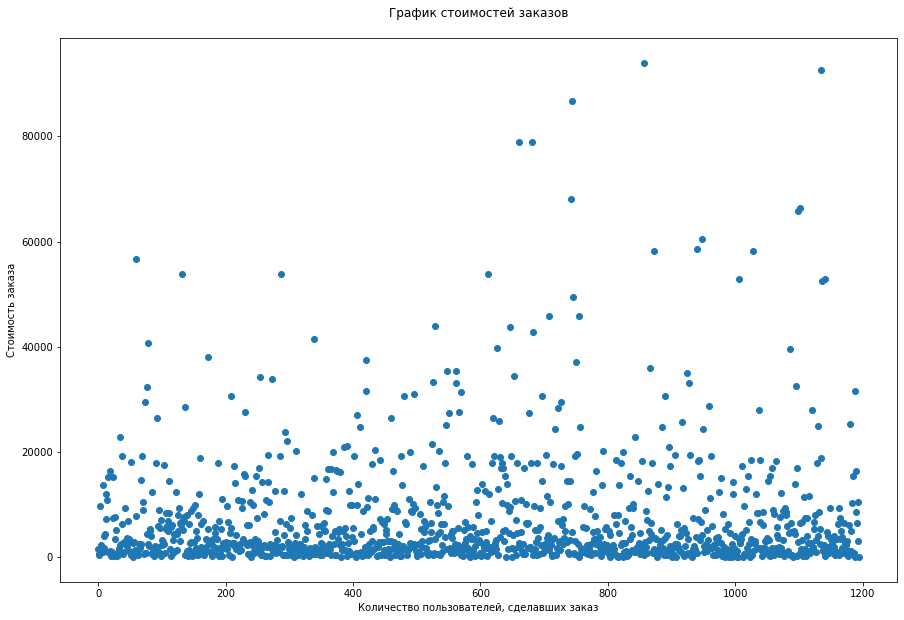

In [30]:
orders_new = orders[orders['revenue'] < 94000]
x_values = pd.Series(range(0, len(orders_new['revenue'])))
plt.figure(figsize=(15,10))
plt.scatter(x_values, orders_new['revenue'])
plt.ylabel('Стоимость заказа')
plt.xlabel('Количество пользователей, сделавших заказ')
plt.title('График стоимостей заказов' + "\n");

Заказов больше чем 50 000 рублей немного. Необходимо убрать аномалии

### Расчет 95-го и 99-го перцентиля стоимости заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов и выберим границу для определения аномальных заказов

In [31]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233 рублей. Выберим в качестве границы для определения аномальных заказов - **58233 рублей**. Так мы уберём 1% пользователей с дорогими заказами

### Расчет статистической значимости различий в конверсии между группами по «сырым» данным

Посчитаем статистическую значимость различий  в среднем числе заказов (конверсии) между группами по «сырым» данным.

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

Начнём с подготовки данных для дальнейшей работы.

Метод, который будем применять для A/B-тестирования, - это непараметрический тест Уилкоксона-Манна-Уитни `st.mannwhitneyu()`. Такой выбор сделан из-за того, что в данных есть большие (по сравнению с нормальным распределением) выбросы

Создадим переменные `ordersByUsersA` и `ordersByUsersB`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. Объявим переменные `sampleA и sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1.

In [32]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value =', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный прирост среднего группы В к конверсии группы А:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
 

P-value = 0.017
Относительный прирост среднего группы В к конверсии группы А: 0.138


P-value = 0.017, т.е. меньше 0.05 (выбранного уровня значимости). Поэтому нулевую гипотезу отвергаем. Анализ "сырых" данных  показывает, что в среднем количестве заказов между группами есть статистически важные различия. Относительный прирост среднего группы В к конверсии группы А равен 13.8%.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между группами по «сырым» данным. 

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

Метод, который будем применять для A/B-тестирования, - это непараметрический тест Уилкоксона-Манна-Уитни `st.mannwhitneyu()`.

In [33]:
print('P-value =', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека между сегментами:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value = 0.729
Относительное различие среднего чека между сегментами: 0.259


P-value значительно больше 0.05 - статистически значимых отличий в среднем чеке между группами нет, т.е. нулевую гипотезу не отвергаем. Относительное различие среднего чека между сегментами 25.9%.

### Расчет статистической значимости различий в конверсии между группами по «очищенным» данным

Узнаем, сколько всего аномальных пользователей

In [34]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
dtype: int64
15


Всего 15 аномальных пользователей

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по "очищенным" данным аналогично тому, как делали это для "сырых" данных

Метод, который будем применять для A/B-тестирования, - это непараметрический тест Уилкоксона-Манна-Уитни `st.mannwhitneyu()`.

In [35]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print('P-value =', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост сегмента В относительно сегмента А:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P-value = 0.014
Относительный прирост сегмента В относительно сегмента А: 0.153


Результаты по среднему количеству заказов практически не изменились. P-value = 0.014, т.е. меньше 0.05, т.е. статистически значимые различия есть, а относительный прирост сегмента В относительно сегмента А 15.3%

### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Теперь посчитаем статистическую значимость различий в среднем чеке заказа между группами теста по "очищенным" данным аналогично тому, как делали это для "сырых" данных

Метод, который будем применять для A/B-тестирования, - это непараметрический тест Уилкоксона-Манна-Уитни `st.mannwhitneyu()`.

In [36]:
print('P-value =',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное различие среднего чека между сегментами:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value = 0.851
Относительное различие среднего чека между сегментами: -0.006


P-value значительно больше 0.05 - статистически значимых отличий в среднем чеке между группами нет, т.е. нулевую гипотезу не отвергаем. Относительное различие среднего чека между сегментами -0.6%.

### Выводы

Исходя из полученных результатов, можно сделать следующие выводы:

* Есть статистически значимое различие по конверсии (среднему количеству заказов) между группами как по сырым данным, так и после фильтрации аномалий,
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий,
* График различия конверсии между группами сообщает, что результаты группы B лучше группы A,
* График различия среднего чека колеблется, результаты группы B лучше группы A только по "сырым" данным, а по "очищенными" чуть хуже.

Исходя из обнаруженных фактов, тест следует остановить, т.к. статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий нет. Стоит отметить, что после удаления аномалий график различия среднего чека по группам стал показывать небольшое ухудшение результатов теста В. 

При этом статистически значимое различие по конверсии (среднему количеству заказов) между группами как по сырым данным, так и после фильтрации аномалий есть, а также график различия конверсии между группами показывает, что результаты группы B лучше группы A. Это то, что мы и хотели получить.

Т.е. разницу по среднему чеку между группами мы не обнаружили, но различия в конверсии между группами есть. Мы частично добились желаемого результата.